In [2]:
# ==========================================================
# 🔍 DIAGNOSTIC: Inspect ALL TensorBoard Log Contents
# ==========================================================
import pandas as pd
import os
from tensorboard.backend.event_processing import event_accumulator

# -------- RUN NAME TO INSPECT --------
run_name = "prb_gym_lstm_seq4_20251114_110136"  # Change this to inspect different runs

log_dir = f"{run_name}"

# -------- LOAD EVENTS --------
try:
    ea = event_accumulator.EventAccumulator(log_dir, size_guidance={'scalars': 0})
    ea.Reload()
    print(f"✅ Successfully loaded TensorBoard log from: {log_dir}\n")
except Exception as e:
    print(f"❌ Error loading log: {e}")
    import sys
    sys.exit(1)

# -------- PRINT ALL AVAILABLE SCALAR TAGS --------
print("=" * 70)
print("📊 ALL AVAILABLE SCALAR TAGS IN TENSORBOARD LOG:")
print("=" * 70)
all_tags = ea.Tags()['scalars']
for i, tag in enumerate(sorted(all_tags), 1):
    print(f"{i:3d}. {tag}")

# -------- SUMMARY STATISTICS --------
print("\n" + "=" * 70)
print("📈 TAG SUMMARY:")
print("=" * 70)
print(f"Total number of unique scalar tags: {len(all_tags)}\n")

# Group by prefix
from collections import defaultdict
tag_groups = defaultdict(list)
for tag in all_tags:
    prefix = tag.split("/")[0]
    tag_groups[prefix].append(tag)

print("Tags grouped by prefix:")
for prefix in sorted(tag_groups.keys()):
    print(f"  {prefix}: {len(tag_groups[prefix])} tags")

# -------- DETAILED INFO PER TAG --------
print("\n" + "=" * 70)
print("🔎 DETAILED INFO PER TAG (sample of first 5 tags):")
print("=" * 70)
for tag in sorted(all_tags)[:5]:
    try:
        scalars = ea.Scalars(tag)
        if scalars:
            values = [s.value for s in scalars]
            steps = [s.step for s in scalars]
            print(f"\n📌 {tag}")
            print(f"   # Points: {len(scalars)}")
            print(f"   Step range: {min(steps):,} → {max(steps):,}")
            print(f"   Value range: {min(values):.6f} → {max(values):.6f}")
            print(f"   Mean: {sum(values) / len(values):.6f}")
        else:
            print(f"\n📌 {tag} - NO DATA")
    except Exception as e:
        print(f"\n📌 {tag} - ERROR: {e}")

print("\n" + "=" * 70)
print("✅ Diagnostic complete!")
print("=" * 70)

✅ Successfully loaded TensorBoard log from: prb_gym_lstm_seq4_20251114_110136

📊 ALL AVAILABLE SCALAR TAGS IN TENSORBOARD LOG:
  1. eval/URLLC/buffer_bytes
  2. eval/URLLC/latency
  3. eval/URLLC/prb_grant_ratio
  4. eval/URLLC/prb_penalty
  5. eval/URLLC/prb_usage_norm
  6. eval/URLLC/prb_usage_prb
  7. eval/URLLC/satisfaction
  8. eval/URLLC/score
  9. eval/URLLC/tx_mbps
 10. eval/eMBB/buffer_bytes
 11. eval/eMBB/latency
 12. eval/eMBB/prb_grant_ratio
 13. eval/eMBB/prb_penalty
 14. eval/eMBB/prb_usage_norm
 15. eval/eMBB/prb_usage_prb
 16. eval/eMBB/satisfaction
 17. eval/eMBB/score
 18. eval/eMBB/tx_mbps
 19. eval/episode_return
 20. eval/epsilon
 21. eval/return_cumulative
 22. eval/reward
 23. eval/reward_running_avg

📈 TAG SUMMARY:
Total number of unique scalar tags: 23

Tags grouped by prefix:
  eval: 23 tags

🔎 DETAILED INFO PER TAG (sample of first 5 tags):

📌 eval/URLLC/buffer_bytes
   # Points: 8775
   Step range: 1 → 8,775
   Value range: 0.000000 → 0.000000
   Mean: 0.000

In [1]:
# ==========================================================
# TensorBoard Slice Analysis → Averaged Summary CSV
# (UPDATED FOR NEW TAG STRUCTURE)
# ==========================================================
import pandas as pd
import os
from tensorboard.backend.event_processing import event_accumulator

# -------- RUN NAME CONFIGURATION --------
run_name = "prb_gym_lstm_seq4_20251114_110136"

# Paths are derived automatically
log_dir = f"{run_name}"
save_dir = f"runs/{run_name}"
os.makedirs(save_dir, exist_ok=True)

# -------- STEP RANGE AND BASE TAGS --------
start_step = 0
end_step = 200_000
slices = ["eMBB", "URLLC"]  # Note: mMTC and All not in new tags

# -------- LOAD EVENTS --------
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

# -------- METRICS TO EXTRACT (UPDATED FOR NEW STRUCTURE) --------
metric_groups = {
    "reward": [
        "eval/reward",
        "eval/reward_running_avg",
        "eval/epsilon",
        "eval/episode_return",
        "eval/return_cumulative",
    ],
    "per_slice": {
        "buffer_bytes":    [f"eval/{s}/buffer_bytes"    for s in slices],
        "latency":         [f"eval/{s}/latency"         for s in slices],
        "prb_grant_ratio": [f"eval/{s}/prb_grant_ratio" for s in slices],
        "prb_penalty":     [f"eval/{s}/prb_penalty"     for s in slices],
        "prb_usage_norm":  [f"eval/{s}/prb_usage_norm"  for s in slices],
        "prb_usage_prb":   [f"eval/{s}/prb_usage_prb"   for s in slices],
        "satisfaction":    [f"eval/{s}/satisfaction"    for s in slices],
        "score":           [f"eval/{s}/score"           for s in slices],
        "tx_mbps":         [f"eval/{s}/tx_mbps"         for s in slices],
    }
}

# -------- HELPER FUNCTION --------
def extract_scalars(tag):
    scalars = ea.Scalars(tag)
    if not scalars:
        return pd.DataFrame(columns=["step", "value"])
    return pd.DataFrame([(s.step, s.value) for s in scalars], columns=["step", "value"])

# -------- BUILD COMBINED DATAFRAME --------
data_dict = {}

# Extract reward metrics
for tag in metric_groups["reward"]:
    name = tag.split("/")[-1]  # Get last part after /
    df = extract_scalars(tag)
    if not df.empty:
        data_dict[name] = df.set_index("step")["value"]

# Extract per-slice metrics
for metric_type, tags in metric_groups["per_slice"].items():
    for tag in tags:
        slice_name = tag.split("/")[1]  # Get slice name (eMBB or URLLC)
        name = f"{slice_name}_{metric_type}"
        df = extract_scalars(tag)
        if not df.empty:
            data_dict[name] = df.set_index("step")["value"]

if not data_dict:
    raise RuntimeError("No scalar data found in the TensorBoard log.")

# Merge all step series
all_steps = sorted(set().union(*[df.index for df in data_dict.values()]))
merged = pd.DataFrame(index=all_steps)
for key, series in data_dict.items():
    merged[key] = series.reindex(merged.index, method="nearest")
merged.reset_index(inplace=True)
merged.rename(columns={"index": "step"}, inplace=True)

# -------- FILTER BY STEP RANGE --------
window_df = merged[(merged["step"] >= start_step) & (merged["step"] <= end_step)]
if window_df.empty:
    raise ValueError(f"No data points between {start_step} and {end_step} steps!")

# ==========================================================
# 1️⃣ COMPUTE AVERAGE SUMMARY
# ==========================================================
print(f"\n===== Averaged metrics from {start_step:,}–{end_step:,} steps =====")

summary = {"run_name": run_name}

# ---- GLOBAL METRICS ----
print("\n=========== GLOBAL METRICS ===========")
for metric in ["reward", "reward_running_avg", "epsilon", "episode_return", "return_cumulative"]:
    if metric in window_df.columns:
        avg_val = window_df[metric].mean()
        summary[metric] = avg_val
        print(f"{metric:20s}: {avg_val:10.6f}")

# ---- PER-SLICE METRICS ----
print("\n=========== PER-SLICE METRICS ===========")
slice_metrics = ["buffer_bytes", "latency", "prb_grant_ratio", "prb_penalty", 
                 "prb_usage_norm", "prb_usage_prb", "satisfaction", "score", "tx_mbps"]

for metric in slice_metrics:
    print(f"\n--- Average {metric} per slice ---")
    for s in slices:
        col = f"{s}_{metric}"
        if col in window_df.columns:
            avg_val = window_df[col].mean()
            summary[col] = avg_val
            print(f"{col:25s}: {avg_val:10.6f}")

# ==========================================================
# 2️⃣ SAVE AVERAGE SUMMARY TO CSV
# ==========================================================
summary_df = pd.DataFrame([summary])
save_path = os.path.join(save_dir, "tensorboard_metrics_full_summary.csv")
summary_df.to_csv(save_path, index=False)

print(f"\n✅ Saved summarized metrics → {save_path}")


2025-11-14 13:12:59.886895: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-14 13:12:59.919759: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-14 13:13:00.582337: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-14 13:13:00.582337: I tensorflow/core/util/port.cc:153


===== Averaged metrics from 0–200,000 steps =====

=========== GLOBAL METRICS ===========
reward              :   0.702128
reward_running_avg  :   0.702270
epsilon             :   0.000000
episode_return      : 280.268862
return_cumulative   : 3082.494954

=========== PER-SLICE METRICS ===========

--- Average buffer_bytes per slice ---
eMBB_buffer_bytes        :   5.672972
URLLC_buffer_bytes       :   0.000000

--- Average latency per slice ---
eMBB_latency             :   0.000082
URLLC_latency            :   0.000000

--- Average prb_grant_ratio per slice ---
eMBB_prb_grant_ratio     :   0.557455
URLLC_prb_grant_ratio    :   0.767506

--- Average prb_penalty per slice ---
eMBB_prb_penalty         :   0.012181
URLLC_prb_penalty        :   0.029339

--- Average prb_usage_norm per slice ---
eMBB_prb_usage_norm      :   0.051833
URLLC_prb_usage_norm     :   0.128295

--- Average prb_usage_prb per slice ---
eMBB_prb_usage_prb       :  11.299567
URLLC_prb_usage_prb      :  27.968323

---

In [2]:
# ==========================================================
# TensorBoard Slice Analysis → Averaged Summary CSV
# (UPDATED FOR NEW TAG STRUCTURE)
# ==========================================================
import pandas as pd
import os
from tensorboard.backend.event_processing import event_accumulator

# -------- RUN NAME CONFIGURATION --------
run_name = "prb_gym_lstm_seq16_20251114_110138"

# Paths are derived automatically
log_dir = f"{run_name}"
save_dir = f"runs/{run_name}"
os.makedirs(save_dir, exist_ok=True)

# -------- STEP RANGE AND BASE TAGS --------
start_step = 0
end_step = 200_000
slices = ["eMBB", "URLLC"]  # Note: mMTC and All not in new tags

# -------- LOAD EVENTS --------
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

# -------- METRICS TO EXTRACT (UPDATED FOR NEW STRUCTURE) --------
metric_groups = {
    "reward": [
        "eval/reward",
        "eval/reward_running_avg",
        "eval/epsilon",
        "eval/episode_return",
        "eval/return_cumulative",
    ],
    "per_slice": {
        "buffer_bytes":    [f"eval/{s}/buffer_bytes"    for s in slices],
        "latency":         [f"eval/{s}/latency"         for s in slices],
        "prb_grant_ratio": [f"eval/{s}/prb_grant_ratio" for s in slices],
        "prb_penalty":     [f"eval/{s}/prb_penalty"     for s in slices],
        "prb_usage_norm":  [f"eval/{s}/prb_usage_norm"  for s in slices],
        "prb_usage_prb":   [f"eval/{s}/prb_usage_prb"   for s in slices],
        "satisfaction":    [f"eval/{s}/satisfaction"    for s in slices],
        "score":           [f"eval/{s}/score"           for s in slices],
        "tx_mbps":         [f"eval/{s}/tx_mbps"         for s in slices],
    }
}

# -------- HELPER FUNCTION --------
def extract_scalars(tag):
    scalars = ea.Scalars(tag)
    if not scalars:
        return pd.DataFrame(columns=["step", "value"])
    return pd.DataFrame([(s.step, s.value) for s in scalars], columns=["step", "value"])

# -------- BUILD COMBINED DATAFRAME --------
data_dict = {}

# Extract reward metrics
for tag in metric_groups["reward"]:
    name = tag.split("/")[-1]  # Get last part after /
    df = extract_scalars(tag)
    if not df.empty:
        data_dict[name] = df.set_index("step")["value"]

# Extract per-slice metrics
for metric_type, tags in metric_groups["per_slice"].items():
    for tag in tags:
        slice_name = tag.split("/")[1]  # Get slice name (eMBB or URLLC)
        name = f"{slice_name}_{metric_type}"
        df = extract_scalars(tag)
        if not df.empty:
            data_dict[name] = df.set_index("step")["value"]

if not data_dict:
    raise RuntimeError("No scalar data found in the TensorBoard log.")

# Merge all step series
all_steps = sorted(set().union(*[df.index for df in data_dict.values()]))
merged = pd.DataFrame(index=all_steps)
for key, series in data_dict.items():
    merged[key] = series.reindex(merged.index, method="nearest")
merged.reset_index(inplace=True)
merged.rename(columns={"index": "step"}, inplace=True)

# -------- FILTER BY STEP RANGE --------
window_df = merged[(merged["step"] >= start_step) & (merged["step"] <= end_step)]
if window_df.empty:
    raise ValueError(f"No data points between {start_step} and {end_step} steps!")

# ==========================================================
# 1️⃣ COMPUTE AVERAGE SUMMARY
# ==========================================================
print(f"\n===== Averaged metrics from {start_step:,}–{end_step:,} steps =====")

summary = {"run_name": run_name}

# ---- GLOBAL METRICS ----
print("\n=========== GLOBAL METRICS ===========")
for metric in ["reward", "reward_running_avg", "epsilon", "episode_return", "return_cumulative"]:
    if metric in window_df.columns:
        avg_val = window_df[metric].mean()
        summary[metric] = avg_val
        print(f"{metric:20s}: {avg_val:10.6f}")

# ---- PER-SLICE METRICS ----
print("\n=========== PER-SLICE METRICS ===========")
slice_metrics = ["buffer_bytes", "latency", "prb_grant_ratio", "prb_penalty", 
                 "prb_usage_norm", "prb_usage_prb", "satisfaction", "score", "tx_mbps"]

for metric in slice_metrics:
    print(f"\n--- Average {metric} per slice ---")
    for s in slices:
        col = f"{s}_{metric}"
        if col in window_df.columns:
            avg_val = window_df[col].mean()
            summary[col] = avg_val
            print(f"{col:25s}: {avg_val:10.6f}")

# ==========================================================
# 2️⃣ SAVE AVERAGE SUMMARY TO CSV
# ==========================================================
summary_df = pd.DataFrame([summary])
save_path = os.path.join(save_dir, "tensorboard_metrics_full_summary.csv")
summary_df.to_csv(save_path, index=False)

print(f"\n✅ Saved summarized metrics → {save_path}")



===== Averaged metrics from 0–200,000 steps =====

=========== GLOBAL METRICS ===========
reward              :   0.694426
reward_running_avg  :   0.694621
epsilon             :   0.000000
episode_return      : 276.794949
return_cumulative   : 3047.455298

=========== PER-SLICE METRICS ===========

--- Average buffer_bytes per slice ---
eMBB_buffer_bytes        :   0.023929
URLLC_buffer_bytes       :   0.000000

--- Average latency per slice ---
eMBB_latency             :   0.000000
URLLC_latency            :   0.000000

--- Average prb_grant_ratio per slice ---
eMBB_prb_grant_ratio     :   0.526062
URLLC_prb_grant_ratio    :   0.768432

--- Average prb_penalty per slice ---
eMBB_prb_penalty         :   0.031181
URLLC_prb_penalty        :   0.026228

--- Average prb_usage_norm per slice ---
eMBB_prb_usage_norm      :   0.132662
URLLC_prb_usage_norm     :   0.114689

--- Average prb_usage_prb per slice ---
eMBB_prb_usage_prb       :  28.920351
URLLC_prb_usage_prb      :  25.002279

---

In [3]:
# ==========================================================
# TensorBoard Slice Analysis → Averaged Summary CSV
# (UPDATED FOR NEW TAG STRUCTURE)
# ==========================================================
import pandas as pd
import os
from tensorboard.backend.event_processing import event_accumulator

# -------- RUN NAME CONFIGURATION --------
run_name = "prb_gym_mlp_20251114_110140"

# Paths are derived automatically
log_dir = f"{run_name}"
save_dir = f"runs/{run_name}"
os.makedirs(save_dir, exist_ok=True)

# -------- STEP RANGE AND BASE TAGS --------
start_step = 0
end_step = 200_000
slices = ["eMBB", "URLLC"]  # Note: mMTC and All not in new tags

# -------- LOAD EVENTS --------
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

# -------- METRICS TO EXTRACT (UPDATED FOR NEW STRUCTURE) --------
metric_groups = {
    "reward": [
        "eval/reward",
        "eval/reward_running_avg",
        "eval/epsilon",
        "eval/episode_return",
        "eval/return_cumulative",
    ],
    "per_slice": {
        "buffer_bytes":    [f"eval/{s}/buffer_bytes"    for s in slices],
        "latency":         [f"eval/{s}/latency"         for s in slices],
        "prb_grant_ratio": [f"eval/{s}/prb_grant_ratio" for s in slices],
        "prb_penalty":     [f"eval/{s}/prb_penalty"     for s in slices],
        "prb_usage_norm":  [f"eval/{s}/prb_usage_norm"  for s in slices],
        "prb_usage_prb":   [f"eval/{s}/prb_usage_prb"   for s in slices],
        "satisfaction":    [f"eval/{s}/satisfaction"    for s in slices],
        "score":           [f"eval/{s}/score"           for s in slices],
        "tx_mbps":         [f"eval/{s}/tx_mbps"         for s in slices],
    }
}

# -------- HELPER FUNCTION --------
def extract_scalars(tag):
    scalars = ea.Scalars(tag)
    if not scalars:
        return pd.DataFrame(columns=["step", "value"])
    return pd.DataFrame([(s.step, s.value) for s in scalars], columns=["step", "value"])

# -------- BUILD COMBINED DATAFRAME --------
data_dict = {}

# Extract reward metrics
for tag in metric_groups["reward"]:
    name = tag.split("/")[-1]  # Get last part after /
    df = extract_scalars(tag)
    if not df.empty:
        data_dict[name] = df.set_index("step")["value"]

# Extract per-slice metrics
for metric_type, tags in metric_groups["per_slice"].items():
    for tag in tags:
        slice_name = tag.split("/")[1]  # Get slice name (eMBB or URLLC)
        name = f"{slice_name}_{metric_type}"
        df = extract_scalars(tag)
        if not df.empty:
            data_dict[name] = df.set_index("step")["value"]

if not data_dict:
    raise RuntimeError("No scalar data found in the TensorBoard log.")

# Merge all step series
all_steps = sorted(set().union(*[df.index for df in data_dict.values()]))
merged = pd.DataFrame(index=all_steps)
for key, series in data_dict.items():
    merged[key] = series.reindex(merged.index, method="nearest")
merged.reset_index(inplace=True)
merged.rename(columns={"index": "step"}, inplace=True)

# -------- FILTER BY STEP RANGE --------
window_df = merged[(merged["step"] >= start_step) & (merged["step"] <= end_step)]
if window_df.empty:
    raise ValueError(f"No data points between {start_step} and {end_step} steps!")

# ==========================================================
# 1️⃣ COMPUTE AVERAGE SUMMARY
# ==========================================================
print(f"\n===== Averaged metrics from {start_step:,}–{end_step:,} steps =====")

summary = {"run_name": run_name}

# ---- GLOBAL METRICS ----
print("\n=========== GLOBAL METRICS ===========")
for metric in ["reward", "reward_running_avg", "epsilon", "episode_return", "return_cumulative"]:
    if metric in window_df.columns:
        avg_val = window_df[metric].mean()
        summary[metric] = avg_val
        print(f"{metric:20s}: {avg_val:10.6f}")

# ---- PER-SLICE METRICS ----
print("\n=========== PER-SLICE METRICS ===========")
slice_metrics = ["buffer_bytes", "latency", "prb_grant_ratio", "prb_penalty", 
                 "prb_usage_norm", "prb_usage_prb", "satisfaction", "score", "tx_mbps"]

for metric in slice_metrics:
    print(f"\n--- Average {metric} per slice ---")
    for s in slices:
        col = f"{s}_{metric}"
        if col in window_df.columns:
            avg_val = window_df[col].mean()
            summary[col] = avg_val
            print(f"{col:25s}: {avg_val:10.6f}")

# ==========================================================
# 2️⃣ SAVE AVERAGE SUMMARY TO CSV
# ==========================================================
summary_df = pd.DataFrame([summary])
save_path = os.path.join(save_dir, "tensorboard_metrics_full_summary.csv")
summary_df.to_csv(save_path, index=False)

print(f"\n✅ Saved summarized metrics → {save_path}")



===== Averaged metrics from 0–200,000 steps =====

=========== GLOBAL METRICS ===========
reward              :   0.679697
reward_running_avg  :   0.680072
epsilon             :   0.000000
episode_return      : 271.200710
return_cumulative   : 2983.617248

=========== PER-SLICE METRICS ===========

--- Average buffer_bytes per slice ---
eMBB_buffer_bytes        :   0.755297
URLLC_buffer_bytes       :   0.000000

--- Average latency per slice ---
eMBB_latency             :   0.000004
URLLC_latency            :   0.000000

--- Average prb_grant_ratio per slice ---
eMBB_prb_grant_ratio     :   0.524331
URLLC_prb_grant_ratio    :   0.763657

--- Average prb_penalty per slice ---
eMBB_prb_penalty         :   0.034678
URLLC_prb_penalty        :   0.051850

--- Average prb_usage_norm per slice ---
eMBB_prb_usage_norm      :   0.147541
URLLC_prb_usage_norm     :   0.226732

--- Average prb_usage_prb per slice ---
eMBB_prb_usage_prb       :  32.163933
URLLC_prb_usage_prb      :  49.427546

---

In [4]:
# ==========================================================
# TensorBoard Slice Analysis → Averaged Summary CSV
# (UPDATED FOR NEW TAG STRUCTURE)
# ==========================================================
import pandas as pd
import os
from tensorboard.backend.event_processing import event_accumulator

# -------- RUN NAME CONFIGURATION --------
run_name = "prb_gym_lstm_seq8_20251115_120534"

# Paths are derived automatically
log_dir = f"{run_name}"
save_dir = f"runs/{run_name}"
os.makedirs(save_dir, exist_ok=True)

# -------- STEP RANGE AND BASE TAGS --------
start_step = 0
end_step = 200_000
slices = ["eMBB", "URLLC"]  # Note: mMTC and All not in new tags

# -------- LOAD EVENTS --------
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

# -------- METRICS TO EXTRACT (UPDATED FOR NEW STRUCTURE) --------
metric_groups = {
    "reward": [
        "eval/reward",
        "eval/reward_running_avg",
        "eval/epsilon",
        "eval/episode_return",
        "eval/return_cumulative",
    ],
    "per_slice": {
        "buffer_bytes":    [f"eval/{s}/buffer_bytes"    for s in slices],
        "latency":         [f"eval/{s}/latency"         for s in slices],
        "prb_grant_ratio": [f"eval/{s}/prb_grant_ratio" for s in slices],
        "prb_penalty":     [f"eval/{s}/prb_penalty"     for s in slices],
        "prb_usage_norm":  [f"eval/{s}/prb_usage_norm"  for s in slices],
        "prb_usage_prb":   [f"eval/{s}/prb_usage_prb"   for s in slices],
        "satisfaction":    [f"eval/{s}/satisfaction"    for s in slices],
        "score":           [f"eval/{s}/score"           for s in slices],
        "tx_mbps":         [f"eval/{s}/tx_mbps"         for s in slices],
    }
}

# -------- HELPER FUNCTION --------
def extract_scalars(tag):
    scalars = ea.Scalars(tag)
    if not scalars:
        return pd.DataFrame(columns=["step", "value"])
    return pd.DataFrame([(s.step, s.value) for s in scalars], columns=["step", "value"])

# -------- BUILD COMBINED DATAFRAME --------
data_dict = {}

# Extract reward metrics
for tag in metric_groups["reward"]:
    name = tag.split("/")[-1]  # Get last part after /
    df = extract_scalars(tag)
    if not df.empty:
        data_dict[name] = df.set_index("step")["value"]

# Extract per-slice metrics
for metric_type, tags in metric_groups["per_slice"].items():
    for tag in tags:
        slice_name = tag.split("/")[1]  # Get slice name (eMBB or URLLC)
        name = f"{slice_name}_{metric_type}"
        df = extract_scalars(tag)
        if not df.empty:
            data_dict[name] = df.set_index("step")["value"]

if not data_dict:
    raise RuntimeError("No scalar data found in the TensorBoard log.")

# Merge all step series
all_steps = sorted(set().union(*[df.index for df in data_dict.values()]))
merged = pd.DataFrame(index=all_steps)
for key, series in data_dict.items():
    merged[key] = series.reindex(merged.index, method="nearest")
merged.reset_index(inplace=True)
merged.rename(columns={"index": "step"}, inplace=True)

# -------- FILTER BY STEP RANGE --------
window_df = merged[(merged["step"] >= start_step) & (merged["step"] <= end_step)]
if window_df.empty:
    raise ValueError(f"No data points between {start_step} and {end_step} steps!")

# ==========================================================
# 1️⃣ COMPUTE AVERAGE SUMMARY
# ==========================================================
print(f"\n===== Averaged metrics from {start_step:,}–{end_step:,} steps =====")

summary = {"run_name": run_name}

# ---- GLOBAL METRICS ----
print("\n=========== GLOBAL METRICS ===========")
for metric in ["reward", "reward_running_avg", "epsilon", "episode_return", "return_cumulative"]:
    if metric in window_df.columns:
        avg_val = window_df[metric].mean()
        summary[metric] = avg_val
        print(f"{metric:20s}: {avg_val:10.6f}")

# ---- PER-SLICE METRICS ----
print("\n=========== PER-SLICE METRICS ===========")
slice_metrics = ["buffer_bytes", "latency", "prb_grant_ratio", "prb_penalty", 
                 "prb_usage_norm", "prb_usage_prb", "satisfaction", "score", "tx_mbps"]

for metric in slice_metrics:
    print(f"\n--- Average {metric} per slice ---")
    for s in slices:
        col = f"{s}_{metric}"
        if col in window_df.columns:
            avg_val = window_df[col].mean()
            summary[col] = avg_val
            print(f"{col:25s}: {avg_val:10.6f}")

# ==========================================================
# 2️⃣ SAVE AVERAGE SUMMARY TO CSV
# ==========================================================
summary_df = pd.DataFrame([summary])
save_path = os.path.join(save_dir, "tensorboard_metrics_full_summary.csv")
summary_df.to_csv(save_path, index=False)

print(f"\n✅ Saved summarized metrics → {save_path}")



===== Averaged metrics from 0–200,000 steps =====

=========== GLOBAL METRICS ===========
reward              :   0.673458
reward_running_avg  :   0.673909
epsilon             :   0.000000
episode_return      : 268.677267
return_cumulative   : 2956.188042

=========== PER-SLICE METRICS ===========

--- Average buffer_bytes per slice ---
eMBB_buffer_bytes        :   0.059695
URLLC_buffer_bytes       :   0.000000

--- Average latency per slice ---
eMBB_latency             :   0.000002
URLLC_latency            :   0.000000

--- Average prb_grant_ratio per slice ---
eMBB_prb_grant_ratio     :   0.519051
URLLC_prb_grant_ratio    :   0.764078

--- Average prb_penalty per slice ---
eMBB_prb_penalty         :   0.051352
URLLC_prb_penalty        :   0.047966

--- Average prb_usage_norm per slice ---
eMBB_prb_usage_norm      :   0.218480
URLLC_prb_usage_norm     :   0.209746

--- Average prb_usage_prb per slice ---
eMBB_prb_usage_prb       :  47.628731
URLLC_prb_usage_prb      :  45.724539

---

## Summary of Changes

### 🔄 Tag Structure Update
Your TensorBoard logs use a **new tag structure** different from the old one. Here's what changed:

| Aspect | Old Structure | New Structure |
|--------|---------------|---------------|
| Base path | `cell/bs_1_cell_mid_freq` | `eval` |
| Slices | eMBB, URLLC, mMTC, All | eMBB, URLLC only |
| Reward tags | `{base}/reward` | `eval/reward` |
| Slice format | `{base}/slice/{slice}/{metric}` | `eval/{slice}/{metric}` |
| New metrics | - | buffer_bytes, latency, prb_grant_ratio, prb_penalty, prb_usage_norm, prb_usage_prb, score |

### ✨ Key Improvements
1. **Simplified tag paths** - No more nested base path
2. **New per-slice metrics** - 9 metrics per slice (vs 4 before)
3. **Better metric names** - More descriptive (e.g., `prb_grant_ratio` instead of just `prb_eMBB`)
4. **Global metrics** - reward, reward_running_avg, epsilon, episode_return, return_cumulative

### Load the csv


In [6]:
import pandas as pd
import glob
import os

# --------------------------------------------------
# Load all summarized CSV files
# --------------------------------------------------
csv_files = glob.glob("runs/**/tensorboard_metrics_full_summary.csv", recursive=True)

dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

# Combine all into one big table
all_data = pd.concat(dataframes, ignore_index=True)

print("=" * 80)
print("📊 LOADED CSV COLUMNS:")
print("=" * 80)
print(all_data.columns.tolist())

print("\n" + "=" * 80)
print("📈 SAMPLE DATA (first 3 runs):")
print("=" * 80)

# Display key metrics from new structure
key_metrics = ["run_name", "reward", "reward_running_avg", "epsilon", 
               "eMBB_tx_mbps", "URLLC_tx_mbps", 
               "eMBB_satisfaction", "URLLC_satisfaction",
               "eMBB_buffer_bytes", "URLLC_buffer_bytes"]

available_cols = [col for col in key_metrics if col in all_data.columns]
print(all_data[available_cols].head(3))

print(f"\n✅ Loaded {len(all_data)} runs")


📊 LOADED CSV COLUMNS:
['run_name', 'reward', 'reward_running_avg', 'epsilon', 'episode_return', 'return_cumulative', 'eMBB_buffer_bytes', 'URLLC_buffer_bytes', 'eMBB_latency', 'URLLC_latency', 'eMBB_prb_grant_ratio', 'URLLC_prb_grant_ratio', 'eMBB_prb_penalty', 'URLLC_prb_penalty', 'eMBB_prb_usage_norm', 'URLLC_prb_usage_norm', 'eMBB_prb_usage_prb', 'URLLC_prb_usage_prb', 'eMBB_satisfaction', 'URLLC_satisfaction', 'eMBB_score', 'URLLC_score', 'eMBB_tx_mbps', 'URLLC_tx_mbps']

📈 SAMPLE DATA (first 3 runs):
                             run_name    reward  reward_running_avg  epsilon  \
0   prb_gym_lstm_seq4_20251114_110136  0.702128            0.702270      0.0   
1         prb_gym_mlp_20251114_110140  0.679697            0.680072      0.0   
2  prb_gym_lstm_seq16_20251114_110138  0.694426            0.694621      0.0   

   eMBB_tx_mbps  URLLC_tx_mbps  eMBB_satisfaction  URLLC_satisfaction  \
0      0.234780       0.123035           0.557455            0.767506   
1      0.234030       

📊 PLOTTING GLOBAL METRICS


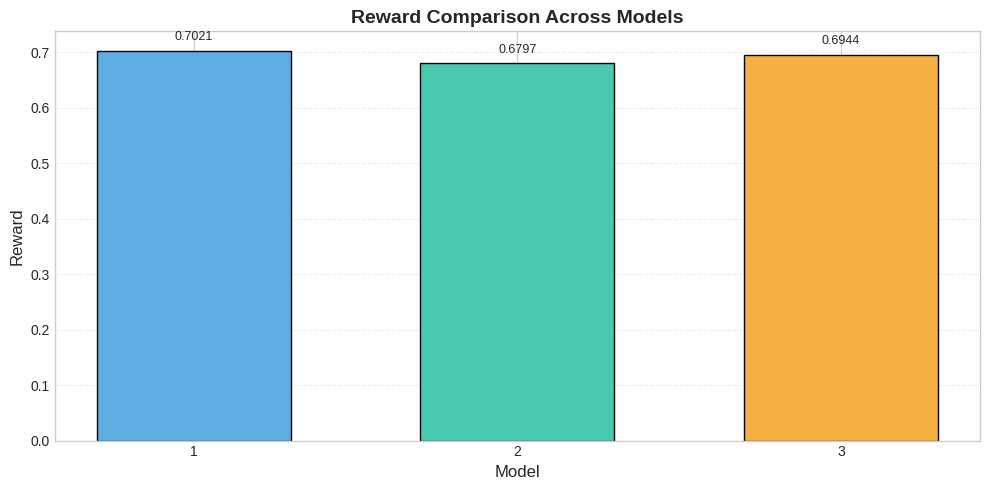

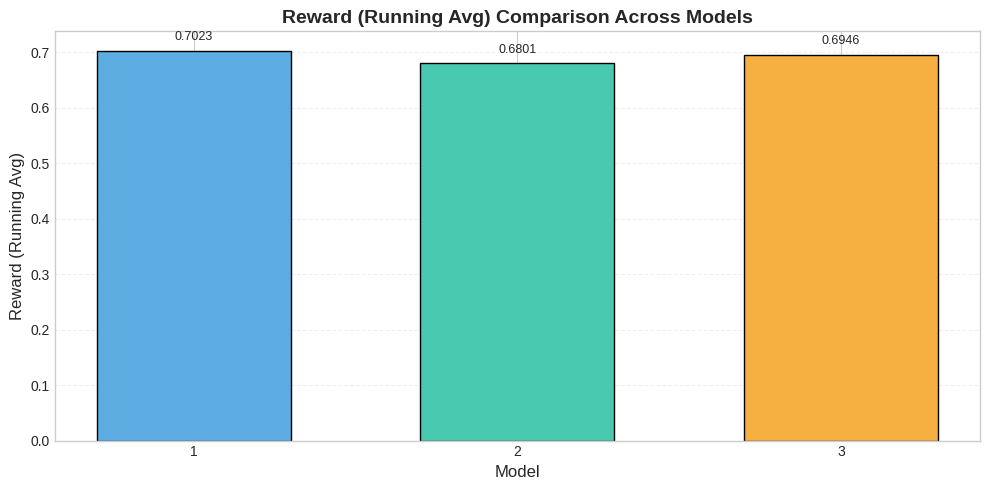

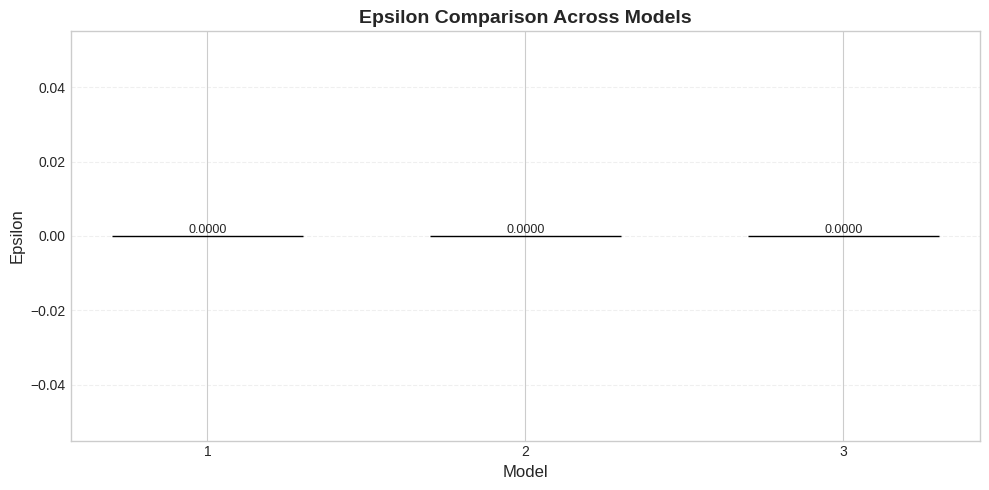

✅ Global metrics plotted


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------
# Extract global metrics (averaged across slices)
# --------------------------------------------------
models = all_data["run_name"].tolist()

# Global reward metrics
global_metrics = {
    "Reward": all_data["reward"].tolist(),
    "Reward (Running Avg)": all_data["reward_running_avg"].tolist(),
    "Epsilon": all_data["epsilon"].tolist(),
}

print("=" * 80)
print("📊 PLOTTING GLOBAL METRICS")
print("=" * 80)

plt.style.use("seaborn-v0_8-whitegrid")

for metric_name, values in global_metrics.items():
    plt.figure(figsize=(10, 5))
    bars = plt.bar(
        range(len(models)),
        values,
        color=["#5DADE2", "#48C9B0", "#F5B041", "#AF7AC5"][:len(models)],
        width=0.6,
        edgecolor='black'
    )

    plt.title(f"{metric_name} Comparison Across Models", fontsize=14, fontweight='bold')
    plt.ylabel(metric_name, fontsize=12)
    plt.xlabel("Model", fontsize=12)
    plt.xticks(range(len(models)), range(1, len(models)+1), fontsize=10)

    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, values)):
        yval = bar.get_height()
        text = f"{val:.4f}" if abs(val) < 100 else f"{val:,.0f}"
        plt.text(bar.get_x() + bar.get_width() / 2, yval * 1.02, text,
                ha='center', va='bottom', fontsize=9)

    plt.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

print("✅ Global metrics plotted")


📊 PLOTTING PER-SLICE METRICS


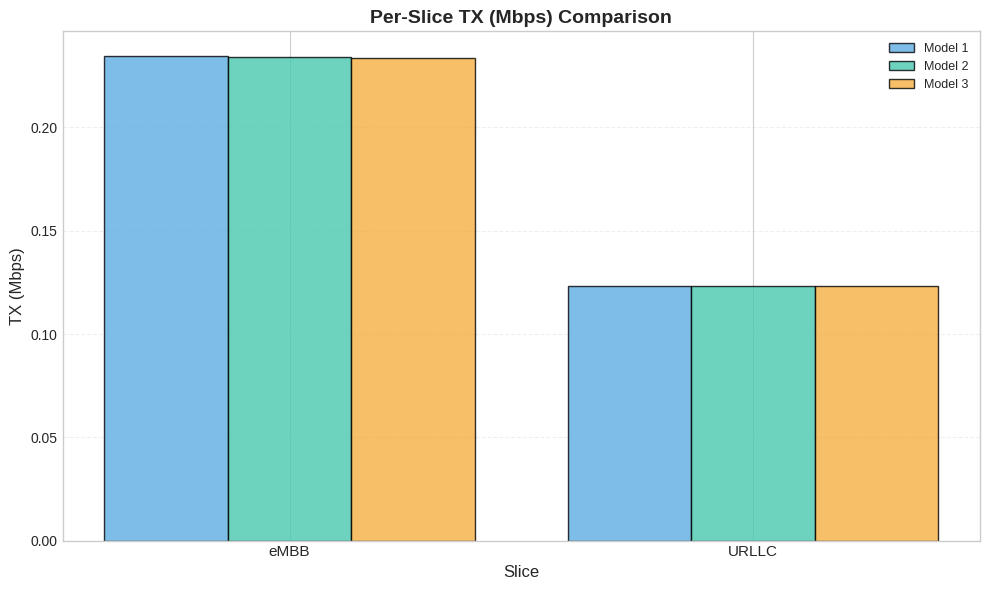

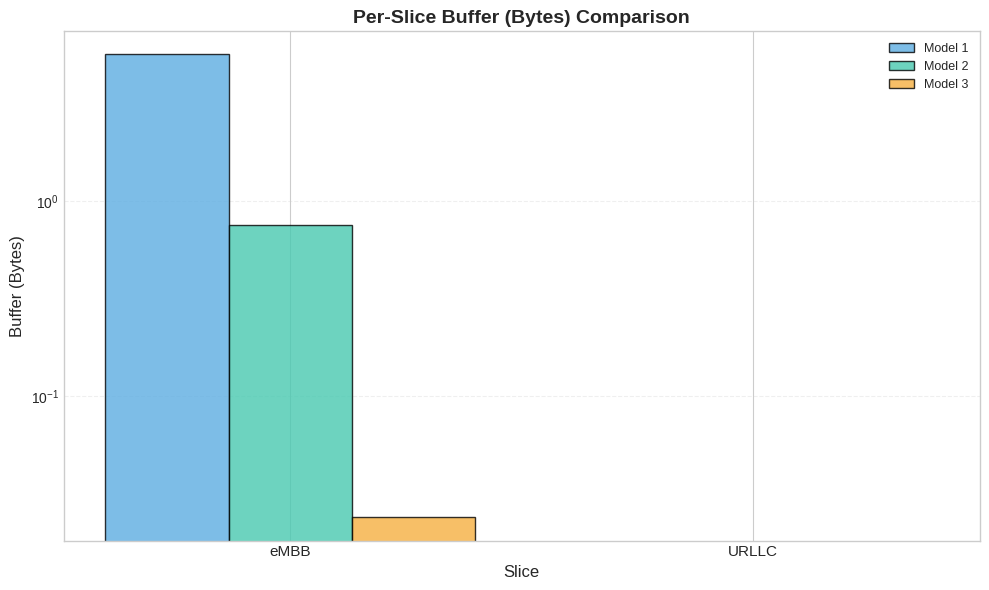

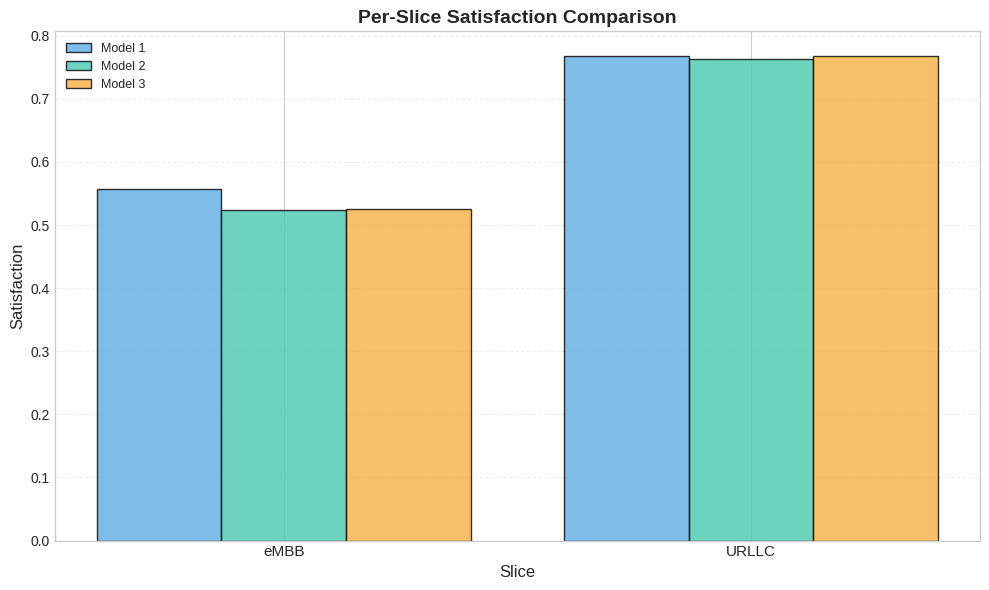

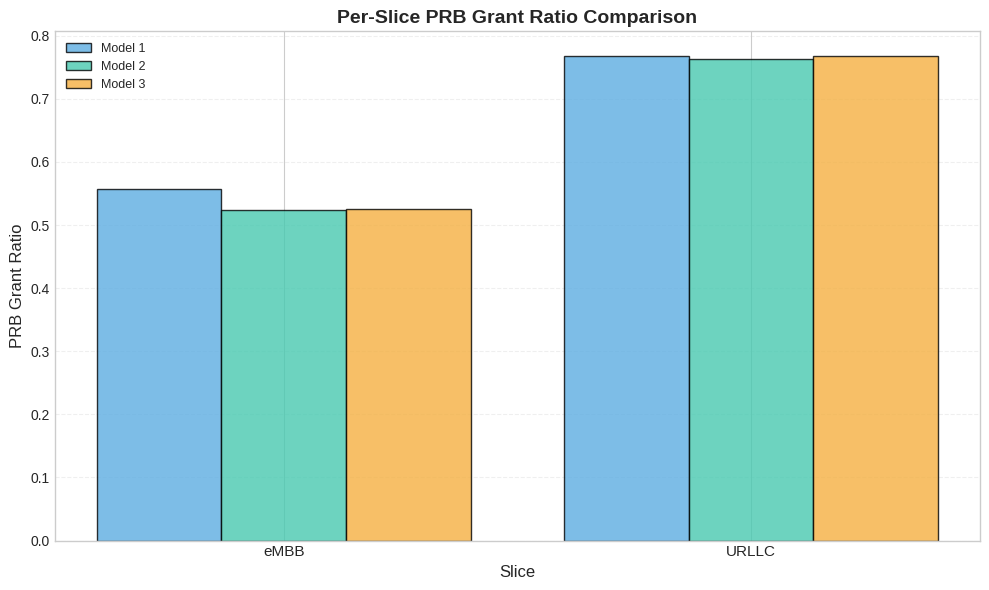

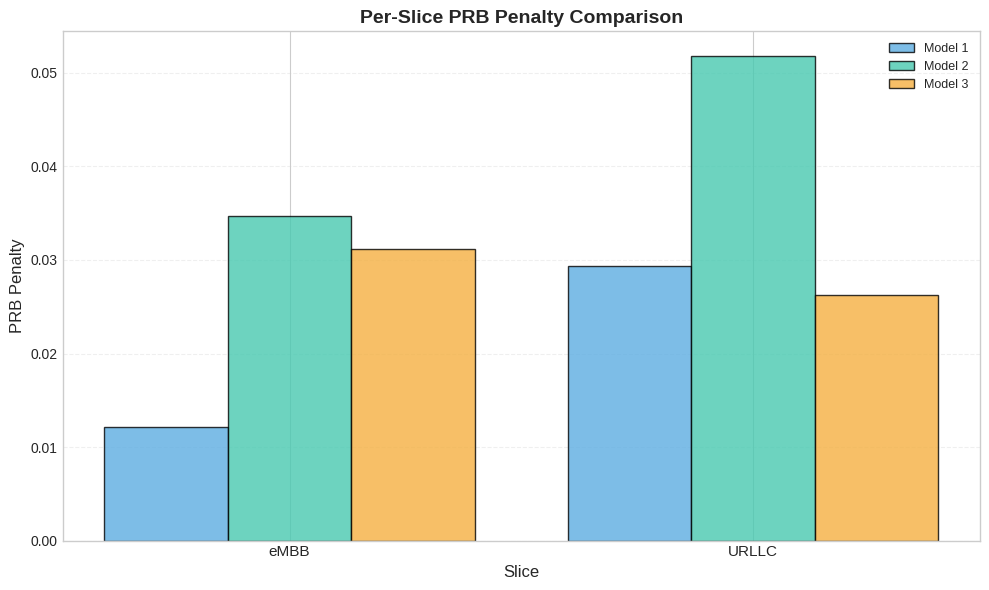

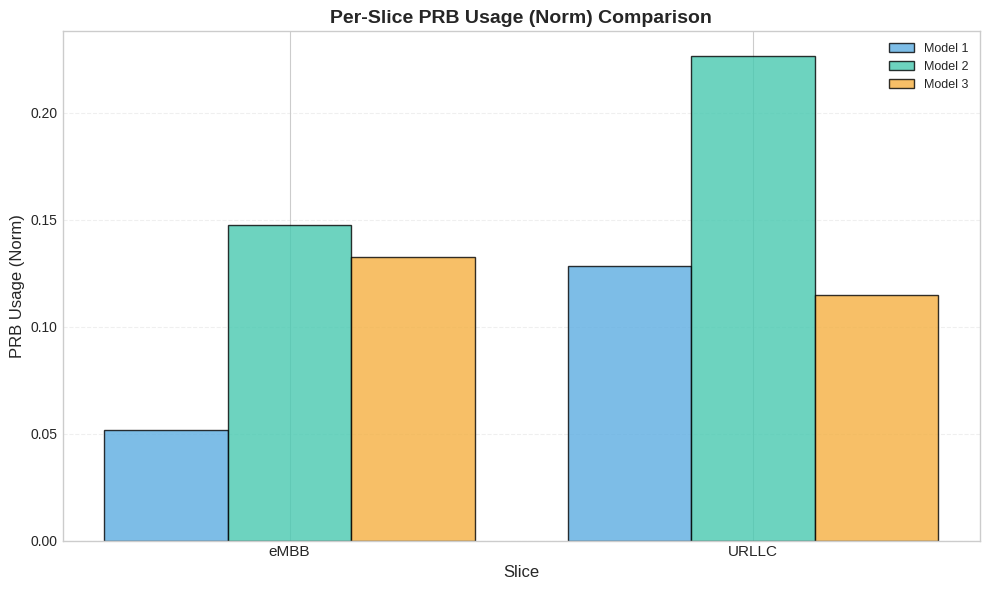

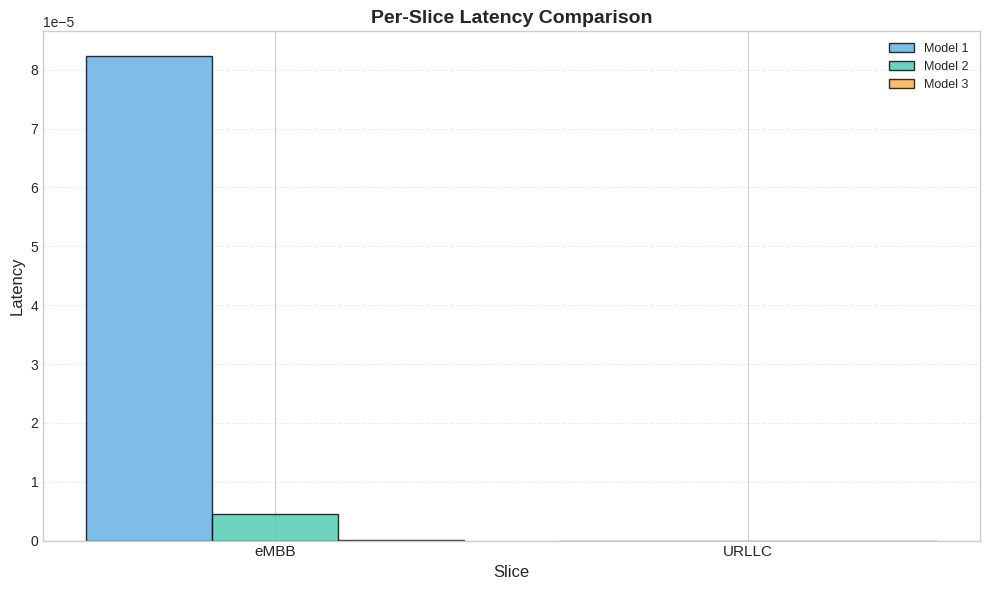

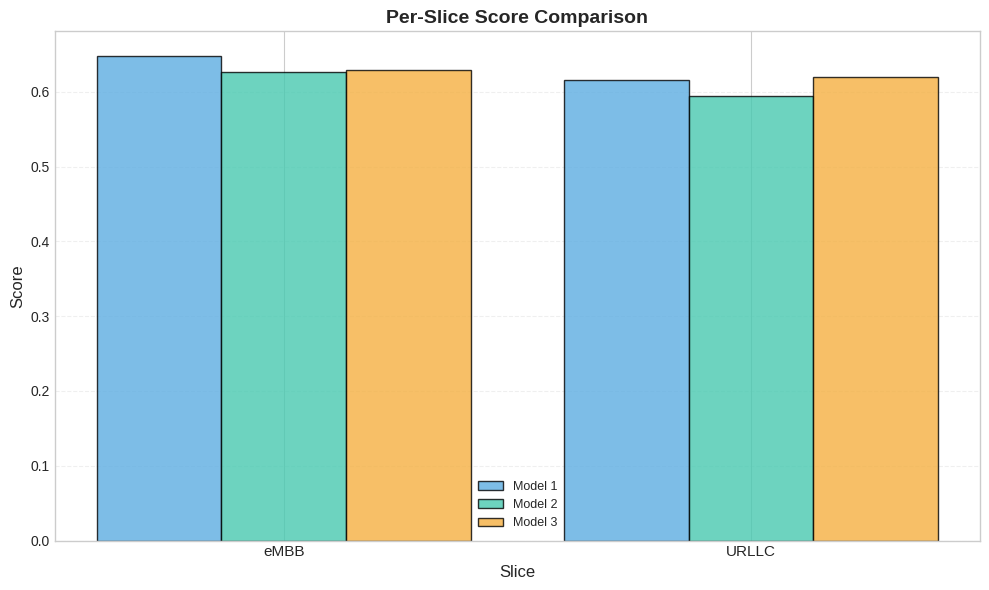

✅ Per-slice metrics plotted


In [8]:
import numpy as np

# --------------------------------------------------
# Define slices and per-slice metrics (based on new structure)
# --------------------------------------------------
slices = ["eMBB", "URLLC"]  # Updated: only eMBB and URLLC available in new logs

# Define metrics to plot per slice
slice_metric_groups = {
    "TX (Mbps)": [f"{s}_tx_mbps" for s in slices],
    "Buffer (Bytes)": [f"{s}_buffer_bytes" for s in slices],
    "Satisfaction": [f"{s}_satisfaction" for s in slices],
    "PRB Grant Ratio": [f"{s}_prb_grant_ratio" for s in slices],
    "PRB Penalty": [f"{s}_prb_penalty" for s in slices],
    "PRB Usage (Norm)": [f"{s}_prb_usage_norm" for s in slices],
    "Latency": [f"{s}_latency" for s in slices],
    "Score": [f"{s}_score" for s in slices],
}

# --------------------------------------------------
# Plot per-slice metrics
# --------------------------------------------------
plt.style.use("seaborn-v0_8-whitegrid")

print("=" * 80)
print("📊 PLOTTING PER-SLICE METRICS")
print("=" * 80)

for metric_name, cols in slice_metric_groups.items():
    # Check if columns exist
    available_cols = [col for col in cols if col in all_data.columns]
    if not available_cols:
        print(f"⚠️  Skipping {metric_name} - no data available")
        continue
    
    plt.figure(figsize=(10, 6))
    x = np.arange(len(slices))
    width = 0.8 / len(all_data)  # space bars evenly for number of runs
    
    # Log scale for buffer because of large differences
    if "Buffer" in metric_name:
        plt.yscale("log")
    
    colors = ["#5DADE2", "#48C9B0", "#F5B041", "#AF7AC5"]
    
    # Plot bars for each model/run
    for i, (_, row) in enumerate(all_data.iterrows()):
        values = [row.get(c, np.nan) for c in cols]
        offset = i * width - (len(all_data) / 2) * width + width / 2
        
        plt.bar(x + offset, values, width, 
                label=f"Model {i+1}" if len(all_data) > 1 else row["run_name"],
                color=colors[i % len(colors)],
                edgecolor='black', alpha=0.8)
    
    plt.title(f"Per-Slice {metric_name} Comparison", fontsize=14, fontweight='bold')
    plt.xlabel("Slice", fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.xticks(x, slices, fontsize=11)
    
    if len(all_data) > 1:
        plt.legend(fontsize=9, loc='best')
    
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

print("✅ Per-slice metrics plotted")
